# Model to predict crash propensity from intersection features in DC
This notebook will train a deep machine learning model and apply its predictions onto the DC case study dataset.

# Imports

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import psycopg2
from geopy.distance import distance as geo_distance
import geopandas as gpd
import pdb
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['axes.linewidth'] = 3
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Analysis idea:

Loop over each intersection. Extract the num crashes within a certain radius. Calculate the number of crashes per yea for each unique intersection. Use gathered intersection features as input variables. Estimate the confidence interval of each prediction using either the RMSE or by fitting the residuals to a laplace distribution.

In [217]:
POSTGRES_DB= 'rws'
POSTGRES_PASSWORD= 'ug_password'
POSTGRES_USER= 'ug_username'
CURRENT_DIR= os.getcwd()
    
conn = psycopg2.connect(f"host=localhost dbname={POSTGRES_DB} user={POSTGRES_USER} password={POSTGRES_PASSWORD} port=5433")


In [218]:
sql_full = f"""
SELECT 
  ni.node_id,
  ni.point3857,
  ni.lat,
  ni.long,
  ni.legs,
  int_feat.way_lines,
  int_feat.ramp_roads,
  int_feat.bikepaths,
  int_feat.footways,
  int_feat.oneways,
  int_feat.maxspeed,
  int_feat.minspeed,
  int_feat.surface_types,
  int_feat.aadt,
  int_feat.min_angle,
  int_feat.second_min_angle,
  int_feat.junction_geometry_type_id,
  int_feat.junction_type_id,
  sum(cast(
  case
        when length(wfv.lanes)>2 then null
        when wfv.lanes is null then null
        when wfv.lanes = '' then null
        else wfv.lanes
    end
    as int
  )) as num_lanes,
 mode() WITHIN GROUP (ORDER BY wfv.highway) AS  highway_type
from 
  rws.dc.node_intersections ni 
inner join 
  rws.dc.intersection_features int_feat  on int_feat.node_id=ni.node_id 
 join 
  rws.dc.curated_way_feature_view wfv on wfv.node_id=ni.node_id  

group by 
  ni.node_id,
  ni.point3857,
  ni.lat,
  ni.long,
  ni.legs,
  int_feat.way_lines,
  int_feat.ramp_roads,
  int_feat.bikepaths,
  int_feat.footways,
  int_feat.oneways,
  int_feat.maxspeed,
  int_feat.minspeed,
  int_feat.surface_types,
  int_feat.aadt,
  int_feat.min_angle,
  int_feat.second_min_angle,
  int_feat.junction_geometry_type_id,
  int_feat.junction_type_id;
"""

df = gpd.read_postgis(sql_full, conn, geom_col="point3857")

/Users/dylan.frizzell/dot/database_building/.venv/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [219]:
df.aadt = df.aadt.apply(lambda x: 5 if float(x) == 5102021.0 else x)

In [220]:
df.sort_values('aadt',ascending=False).head(5)

,node_id,point3857,lat,long,legs,way_lines,ramp_roads,bikepaths,footways,oneways,maxspeed,minspeed,surface_types,aadt,min_angle,second_min_angle,junction_geometry_type_id,junction_type_id,num_lanes,highway_type
26082,6003858244,POINT (-8575939.045 4704369.266),38.879106,-77.038971,3,0105000020110F000003000000010200000002000000CF...,0,0,0,3,40 mph,35 mph,None,248561.0,4.422229,169.934703,2.0,1,8.0,motorway
8086,486665753,POINT (-8575993.926 4704268.639),38.878402,-77.039464,3,0105000020110F00000300000001020000000200000071...,2,0,0,3,65 mph,65 mph,[concrete],248561.0,10.768784,166.895809,NaN,2,4.0,motorway_link
7224,49859243,POINT (-8575771.198 4704220.536),38.878066,-77.037463,3,0105000020110F00000300000001020000000200000036...,0,0,0,3,40 mph,35 mph,[asphalt],248561.0,17.181792,168.054609,2.0,1,9.0,motorway
7225,49859315,POINT (-8576018.182 4704211.227),38.878000,-77.039682,3,0105000020110F00000300000001020000000200000012...,2,0,0,3,65 mph,65 mph,[concrete],248561.0,10.305202,172.537383,NaN,2,4.0,motorway_link
8613,643754239,POINT (-8576457.850 4703700.432),38.874428,-77.043632,3,0105000020110F000003000000010200000002000000E7...,1,0,0,3,None,None,None,248561.0,16.109101,163.510839,NaN,2,9.0,motorway


# The following code build a dataset of historical crash data

In [221]:

sql_crashes = f"""SELECT *,ST_AsText(dc.point) as t_point from rws.dc.crashes as dc """

df_crashes = gpd.read_postgis(sql_crashes, conn,geom_col="point")


/Users/dylan.frizzell/dot/database_building/.venv/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [222]:
df_crashes.head()

,x,y,objectid,crimeid,ccn,reportdate,routeid,measure,offset,streetsegid,roadwaysegid,fromdate,todate,marid,address,latitude,longitude,xcoord,ycoord,ward,eventid,mar_address,mar_score,majorinjuries_bicyclist,minorinjuries_bicyclist,unknowninjuries_bicyclist,fatal_bicyclist,majorinjuries_driver,minorinjuries_driver,unknowninjuries_driver,fatal_driver,majorinjuries_pedestrian,minorinjuries_pedestrian,unknowninjuries_pedestrian,fatal_pedestrian,total_vehicles,total_bicycles,total_pedestrians,pedestriansimpaired,bicyclistsimpaired,driversimpaired,total_taxis,total_government,speeding_involved,nearestintrouteid,nearestintstreetname,offintersection,intapproachdirection,locationerror,lastupdatedate,mpdlatitude,mpdlongitude,mpdgeox,mpdgeoy,blockkey,subblockkey,fatalpassenger,majorinjuriespassenger,minorinjuriespassenger,unknowninjuriespassenger,point,node_id,t_point
0,-77.0464004444425,38.8951760840131,235078103,28104938,19124624,2019/07/16 22:51:42+00,11089892,632.8,9.51,None,None,2019/07/16 04:00:00+00,None,242542,2121 VIRGINIA AVENUE NW,38.896385,-77.047833,395850.594,136505.031,Ward 2,{FCE3B7A0-CD00-48C2-927C-49A4C25F271B},2121 VIRGINIA AVENUE NW,200,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,11002102,21ST ST NW,29.58,Southeast,None,2021/03/02 15:34:54+00,38.895097,-77.046459,395821.03,136510.42,None,None,0,0,0,0,POINT (-8576925.536 4706840.462),NaN,POINT(-8576925.536285179 4706840.461730277)
1,-76.943743497768,38.90052928229,235078106,28107848,19126333,2019/07/19 20:10:57+00,12047192,53.24,6.83,None,None,2019/07/19 04:00:00+00,None,288109,4100 HUNT PLACE NE,38.90109,-76.943657,404887.297,137027.779,Ward 7,{DC015601-01BF-4F15-B460-7077B9B4758D},4100 HUNT PLACE NE,200,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,47078992,Alley-47078992,3.9,West,None,None,38.90046,-76.943741,404910.56,137005.15,None,None,0,0,0,0,POINT (-8565328.717 4707513.450),NaN,POINT(-8565328.7170123 4707513.4504915355)
2,-77.0040534623968,38.9090923670921,235078111,28107881,19126542,2019/07/19 21:30:36+00,0,0,4.32,None,None,2019/07/19 04:00:00+00,None,313071,244 NEW YORK AVE NE,38.909982,-77.001459,399873.439,138013.362,Ward 5,{82441428-2E7D-4EDB-B7F6-CAB89176209D},None,200,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,Not Available,0,East,None,None,38.909049,-77.004031,399873.44,138013.36,None,None,0,0,0,0,POINT (-8571763.206 4708785.457),NaN,POINT(-8571763.206219133 4708785.4566755835)
3,-76.997842261169,38.863243725352,235078108,28107858,19126463,2019/07/19 20:35:59+00,0,0,0.01,None,None,2019/07/19 04:00:00+00,None,309448,INTERSTATE 295 INTERSTATE BN,38.863236,-76.99784,399975.57,132781.53,Ward 8,{18BB8C27-462B-4C96-A2D7-68183115B92A},None,200,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,Not Available,0,East,None,None,38.863236,-76.99784,399975.57,132781.53,None,None,0,0,0,0,POINT (-8571360.341 4702100.194),9.315321e+09,POINT(-8571360.340981951 4702100.1935498305)
4,-77.0416708676798,38.9104819118283,235078130,28073589,19104073,2019/06/15 07:35:54+00,11001802,2032.52,7.51,0,0,2019/06/14 04:00:00+00,None,226107,1545 18TH STREET NW,38.910725,-77.041093,396435.991,138096.65,Ward 2,{EBDFE007-7676-4781-8C67-923756D12031},1545 18TH STREET NW,200,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,11023402,CHURCH ST NW,9.7,North,None,None,38.910474,-77.041582,396436,138113.79,None,None,0,0,0,0,POINT (-8576175.243 4708891.751),NaN,POINT(-8576175.242917232 4708891.75050524)


# Format datatypes and define exposure window
The idea is that the crash data is collected from various sources. By looking at the data it seems there are fairly uniform collections from 2009-2022. So the strategy is going to use this time frame as our exposure time (time we are recording data in DC), and assume all intersection crashes are accurately recorded during this time. 

In [223]:
# print([x for x in df_crashes.columns])

new_dtypes = { 
#     "crash_severity": int,
              "majorinjuries_driver": int,
              "majorinjuries_pedestrian": int,
              "majorinjuriespassenger": int,
              "fatal_driver": int,
              "fatal_pedestrian": int,
              "fatalpassenger": int,
              "fatal_bicyclist": int,
#               "num_legs": int
             }
df_crashes = df_crashes.astype(new_dtypes)
# dataframe = dataframe.astype(new_dtypes)


df_crashes['reportdate'] =  pd.to_datetime(df_crashes['reportdate'])

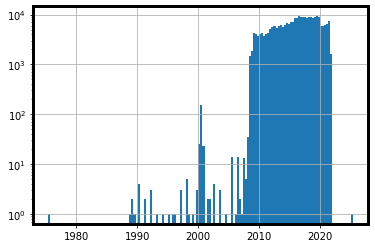

In [224]:
df_crashes['reportdate'].hist(bins=150)
plt.yscale('log')
plt.show()

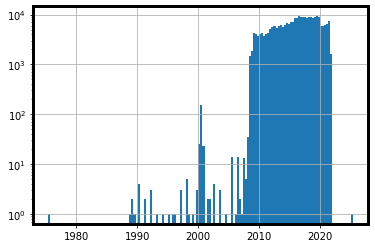

2009-01-01 05:00:00+00:00
2019-12-31 23:59:56+00:00
4016 days 18:59:56
We will normalize the crashes to an exposure time of 11 +- 0.5 years


<AxesSubplot:>

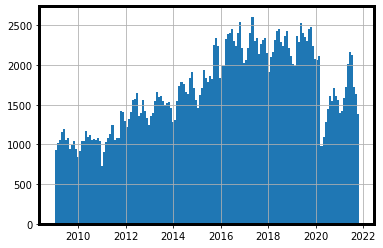

In [225]:
df_crashes['reportdate'].hist(bins=150)
plt.yscale('log')
plt.show()
print(df_crashes[(df_crashes['reportdate'] > "2009") &(df_crashes['reportdate'] < "2020") ]['reportdate'].min())
print(df_crashes[(df_crashes['reportdate'] > "2009") &(df_crashes['reportdate'] < "2020") ]['reportdate'].max())
print((df_crashes[(df_crashes['reportdate'] > "2009") &(df_crashes['reportdate'] < "2020") ]['reportdate'].max())-\
      (df_crashes[(df_crashes['reportdate'] > "2009") &(df_crashes['reportdate'] < "2020") ]['reportdate'].min()))
print("We will normalize the crashes to an exposure time of 11 +- 0.5 years")

df_crashes[(df_crashes['reportdate'] > "2009") &(df_crashes['reportdate'] < "2022") ]['reportdate'].hist(bins=150)
# plt.yscale('log')

In [226]:
exposure_time = 11
exposure_time_up = 11.5
exposure_time_down = 10.5
df_crashes = df_crashes[(df_crashes['reportdate'] > "2009") &(df_crashes['reportdate'] < "2020") ]
# For now we will ignore systematic uncertainties

# severe_columns = [x for x in df_crashes.columns if "FATAL" in x.upper() or "MAJOR" in x.upper()]
# df_crashes_severe = df_crashes[ pd.DataFrame.any(df_crashes[severe_columns].astype(int) > 0,axis=1) ]

# Major calculation section of the notebook - associating crashes to intersections
Loop over intersections and calculate the crash rates for all, severe, and fatal crashes per intersection.

In [227]:
# temp = df
temp_crashes = df_crashes.copy()
temp_crashes.geometry = df_crashes.geometry.buffer(15)
full = gpd.sjoin(df,temp_crashes,op='within')

minor_crashes_lookup = full[['node_id_left','mar_score']]\
[(full['total_vehicles'].apply(int)==2) &\
 ~((full['minorinjuries_driver']>0) |\
   (full['minorinjuriespassenger']>0) |\
   (full['fatal_driver']>0) |\
   (full['fatalpassenger']>0) |\
   (full['minorinjuries_bicyclist'].apply(int)>0) |\
   (full['minorinjuries_pedestrian'].apply(int)>0))].groupby('node_id_left').count()/11 #years

major_crashes_lookup = full[['node_id_left','mar_score']]\
[(full['total_vehicles'].apply(int)==2) &\
 ((full['majorinjuries_driver']>0) |\
   (full['majorinjuriespassenger']>0) |\
   (full['fatal_driver']>0) |\
   (full['fatalpassenger']>0) |\
   (full['majorinjuries_bicyclist'].apply(int)>0) |\
   (full['majorinjuries_pedestrian'].apply(int)>0))].groupby('node_id_left').count()/11 #years 


/Users/dylan.frizzell/dot/database_building/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


#### Clean up the lookup tables

In [228]:
df.index = df.node_id
minor_crashes_lookup.index.rename('node_id',inplace=True)
minor_crashes_lookup.rename(columns={'mar_score':"minor_crashes"},inplace=True)
major_crashes_lookup.index.rename('node_id',inplace=True)
major_crashes_lookup.rename(columns={'mar_score':"major_crashes"},inplace=True)

In [229]:
final = df.join(minor_crashes_lookup).join(major_crashes_lookup)
# minor_crashes_lookup.loc[30993407]

### Count number of nearby intersections
And create compound feature variables based on spatial context

In [230]:
temp_final = final.copy()
temp_final.geometry = temp_final.geometry.buffer(50)


In [231]:
final_self_join = gpd.sjoin(final,temp_final,op="within")

/Users/dylan.frizzell/dot/database_building/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [232]:
average_aadt_lookup = final_self_join[['node_id_left','aadt_right']].groupby('node_id_left').mean()
node_density_lookup = final_self_join[['node_id_left','aadt_right']].groupby('node_id_left').count()


In [233]:
average_aadt_lookup.rename(columns={'node_id_left':'node_id',
                                    'aadt_right':'aadt_mean'},inplace=True)
node_density_lookup.rename(columns={'node_id_left':'node_id',
                                    'aadt_right':'node_density'},inplace=True)

In [234]:
final = final.join(average_aadt_lookup).join(node_density_lookup)

#### Apply a few data cleaning steps

In [235]:
final["maxspeed"] = final['maxspeed'].apply(lambda x : str(x).replace("mph","").replace(" mph","").replace('35, 25 When Lights Flash','35').replace('15, 30','30') if x else np.nan).apply(lambda x: x if x != "24.14" else np.nan).astype(float)
final["minspeed"] = final['minspeed'].apply(lambda x : str(x).replace("mph","").replace(" mph","").replace('35, 25 When Lights Flash','35').replace('15, 30','30') if x else np.nan).apply(lambda x: x if x != "24.14" else np.nan).astype(float)



In [236]:
final['min_angle'] = final['min_angle'].apply(float)
final['second_min_angle'] = final['second_min_angle'].apply(float)
final['second_min_angle'] = final['second_min_angle'].apply(float)
final['surface_types'] = final['surface_types'].apply(lambda x : x[0] if x else np.nan)

In [237]:
final['major_crashes'] = final.major_crashes.fillna(0)
final['minor_crashes'] = final.minor_crashes.fillna(0)

# Save the final input dataset as a temporary csv file
This one one can recreate the analysis without standing up the entire postgres database.

In [238]:
# df_int.head(50)
final.to_csv('dc_df_before_modeling.csv')

In [491]:
target_var = "major_crashes"# "major_crashes"

X = final[[
        'legs',
       'ramp_roads',
       'oneways',
       'maxspeed',
       'minspeed',
       'surface_types',
       'aadt',
       'min_angle',
       'second_min_angle',
       'junction_geometry_type_id',
       'junction_type_id',
       'num_lanes',
       'highway_type',
       'aadt_mean',
       'node_density',
#        'minor_crashes',
#        'major_crashes'
      ]].copy()

X = X[~X.aadt.isna().values]
# For some fields if there are blank entries we will take the most common as grouped by highway type

lookup_X = X.groupby('highway_type').mean()

for i,row in X.iterrows():
    if np.isnan(row['maxspeed']):
#         print("blah")
#         row['aadt'] = X[X.highway_type == row['highway_type']]['aadt'].mean()
#         row['aadt_mean'] = X[X.highway_type == row['highway_type']]['aadt_mean'].mean()
        row['maxspeed'] = lookup_X.loc[row['highway_type']]['maxspeed']
        row['minspeed'] = lookup_X.loc[row['highway_type']]['minspeed']
    if np.isnan(row['aadt']):
#         print("blah")
#         row['aadt'] = X[X.highway_type == row['highway_type']]['aadt'].mean()
#         row['aadt_mean'] = X[X.highway_type == row['highway_type']]['aadt_mean'].mean()
        row['aadt'] = lookup_X.loc[row['highway_type']]['aadt']
#         row['minspeed'] = lookup_X.loc[row['highway_type']]['minspeed']
#         row['surface_types'] = X[X.highway_type == row['highway_type']]['surface_types'].mode()


y = final[[target_var,
      ]] 

y = y.loc[X.index.values]

# X['aadt'] = np.nan
# X['node_density'] = np.nan



In [516]:
print("95% CL +/- using Poisson distribution" + str(np.sqrt( np.mean((y - y.mean())**2 ))*2.1))

95% CL +/- using Poisson distributionmajor_crashes    0.261612
dtype: float64


/Users/dylan.frizzell/dot/database_building/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [493]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
import joblib
from sklearn.metrics import explained_variance_score


In [494]:
# clf = joblib.load('iowa_trained.pkl')

In [495]:

numeric_features = [
                    "oneways",
                    "maxspeed",
                    "minspeed",
                    "min_angle",
                    "second_min_angle",
                    "num_lanes",
                    "aadt",
                    'aadt_mean',
                    'node_density',
                   ]
numeric_transformer = Pipeline(
    steps=[
           ("imputer", SimpleImputer(strategy="median")),
#            ('poly',PolynomialFeatures()),
           ("scaler", StandardScaler()) , ]
)

categorical_features = [
        'legs',
       'ramp_roads',
       'surface_types',
       'junction_geometry_type_id',
        'junction_type_id',
       'highway_type',
      ]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
                ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


lr = [0.0002]
depth = [8,]
nodes = [125,]

experiments = []
for l in lr:
    for d in depth:
        for n in nodes:

            clf = Pipeline(
                steps=[("preprocessor", preprocessor),
                       ("model", 
                                MLPRegressor((n)*d,
                                                learning_rate_init=l,
                                                 alpha=0.5,
                                                random_state=1,early_stopping=True,
                                                max_iter=500)
                       )]
            )

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
            clf.fit(X_train, np.ravel(y_train))
            score = clf.score(X_test, y_test)
            print("Explained variance: %.3f" % score)
#             explained_variance_score(y_test[target_var].values,clf.predict(X_test))
            
            experiments.append({'depth':d,
                                'learning rate': l,
                                'nodes': n,
                                'score': score})

Explained variance: 0.244


### The explained variance above 
describes the percent of the test set's variance that can be explained away with the model

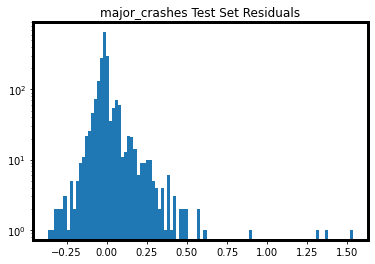

The 95% CL interval for the predictions can be estiamted to be +/- 0.21985418502107693


In [496]:
plt.hist( (y_test[target_var].values-clf.predict(X_test)),bins=100)
plt.title(target_var +' Test Set Residuals')
plt.yscale("log")
plt.show()

print("The 95% CL interval for the predictions can be estiamted to be +/- " +\
      str(np.sqrt(np.mean( (y_test[target_var].values - clf.predict(X_test))**2 ) )*2.1))


### To make sure there is no overtraining,
We will also check the training set's residuals. If these two distributions have similar width, we can say there is negligible overtraining.

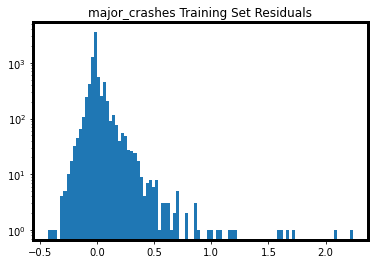

The 95% CL interval for the predictions can be estiamted to be +/- 0.22591835966607832


In [497]:
plt.hist(y_train[target_var].values-clf.predict(X_train),bins=100)
plt.title(target_var +' Training Set Residuals')
plt.yscale("log")
plt.show()
print("The 95% CL interval for the predictions can be estiamted to be +/- " +\
      str(np.sqrt(np.mean( (y_train[target_var].values - clf.predict(X_train))**2 ) )*2.1))

### Apply the model predictions to the full dataset

In [498]:
final['predicted_'+target_var] = clf.predict(final)

In [503]:
final.to_csv("dc_case_study.csv")

In [514]:

# clf.predict(final)
# final.sort_values('predicted_'+target_var,ascending=False).head(25)


/Users/dylan.frizzell/dot/database_building/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


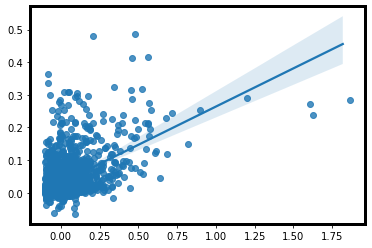

In [520]:
# plt.scatter(y_test[target_var].values , clf.predict(X_test))
# plt.title("Prediction vs. Target")
# plt.show()
ax = sns.regplot(y_test[target_var].values , clf.predict(X_test), x_jitter=0.1,)


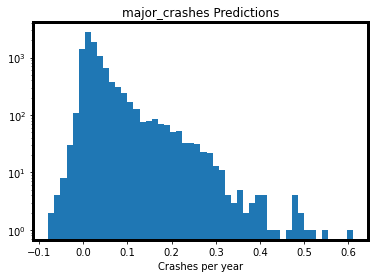

In [505]:
plt.hist(clf.predict(X),bins=50)
plt.title(target_var + " Predictions")
plt.xlabel('Crashes per year')

plt.yscale("log")
plt.show()

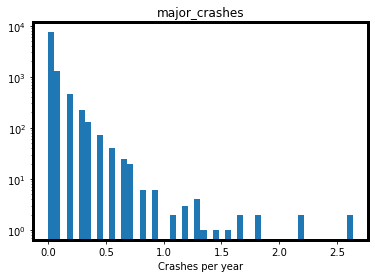

In [506]:
plt.hist(y[target_var].values,bins=50)
plt.title(target_var)
plt.xlabel('Crashes per year')
plt.yscale("log")
plt.show()